In [84]:
import os
import imageio
import matplotlib.pyplot as plt
import cv2
%matplotlib widget
%load_ext autoreload
%autoreload 2
from amftrack.pipeline.functions.image_processing.extract_graph import (
    from_sparse_to_graph,
    generate_nx_graph,
    clean_degree_4,
)
import scipy
from amftrack.pipeline.functions.image_processing.node_id import remove_spurs
from amftrack.pipeline.functions.image_processing.extract_skel import remove_component, remove_holes
import numpy as np
from amftrack.pipeline.development.high_mag_videos.high_mag_videos_fun import *
from scipy import signal
import math
def gridplot(
    n: int,
    ncols = None,
    subw: float = 4.0,
    subh: float = 4.0,
    **kwargs,
):
    if ncols is None:
        ncols = n
    nrows = math.ceil(n / ncols)
    figsize = (subw * ncols, subh * nrows)
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize, **kwargs)
    return fig, iter(axs.flatten())
def frame_num(file):
    return(int(file.split('_')[-1].split('.')[0]))
def movie_num(file):
    return(file.split('_')[-2])
plt.style.use('presentation.mplstyle')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
images_path = r"/mnt/sun/home-folder/Jaap/Transport setup 4 x NileRed/All frames"
files = os.listdir(images_path)
images_total_path = [os.path.join(images_path,file) for file in files]
images_total_path.sort()

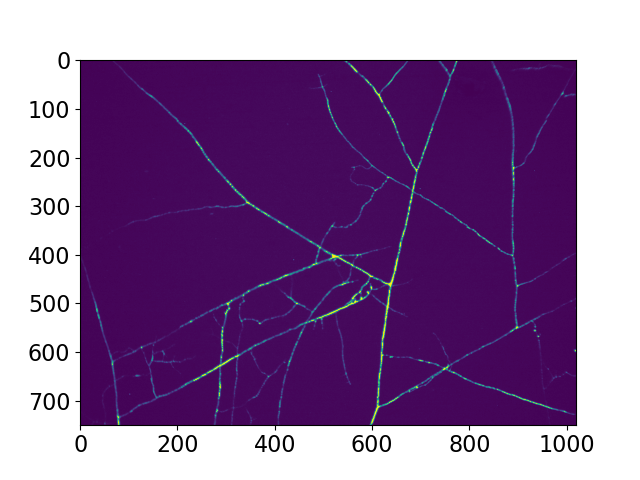

In [210]:
range_interest = range(4900,8000)
selection_file = [file for file in images_total_path if frame_num(file) in range_interest]
selection_file = [file for file in selection_file if movie_num(file)=='150115688']
selection_file.sort()
image = imageio.imread(selection_file[-1])
fig, ax = plt.subplots()
ax.imshow(image)

In [4]:
skeletonized,nx_graph_pruned,pos = segment(selection_file[:100])

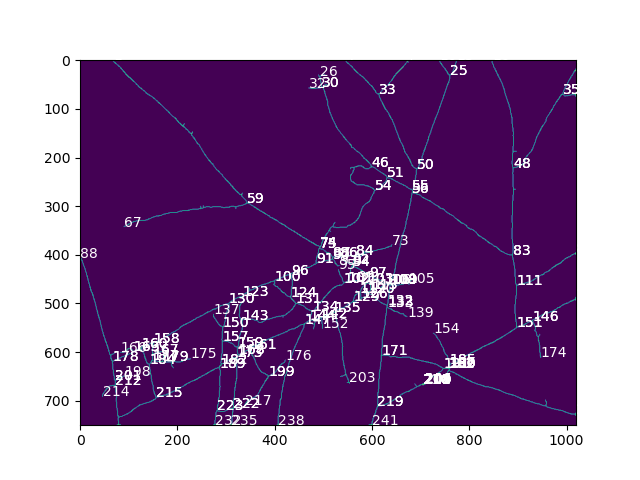

In [5]:
fig, ax = plt.subplots()
ax.imshow(skeletonized)
for edge in list(nx_graph_pruned.edges):
    ax.text(*np.flip(pos[edge[0]]),str(edge[0]),color="white")
    ax.text(*np.flip(pos[edge[1]]),str(edge[1]),color="white")

In [126]:
edges = [(109,56),(50,33),(83,48),(74,59),(185,151),(35,48),(48,16),(59,1),(219,171),(171,133),(50,25),(191,171),(223,189),(225,192)]

In [208]:
slices, segments = extract_section_profiles_for_edge(
    edge,
    pos,
    image,
    nx_graph_pruned,
    resolution=1,
    offset=4,
    step=15,
    target_length=10,
)

In [219]:
def get_width(edge,pos,image,nx_graph_pruned,resolution,offset,step,target_length):
    slices, segments = extract_section_profiles_for_edge(
    edge,
    pos,
    image,
    nx_graph_pruned,
    resolution,
    offset,
    step,
    target_length,
)
    return(np.mean([np.sum(slici>=10) for slici in slices]))

In [222]:
widths = {edge : get_width(edge,pos,image,nx_graph_pruned,resolution=1,
    offset=4,
    step=15,
    target_length=10) for edge in edges}

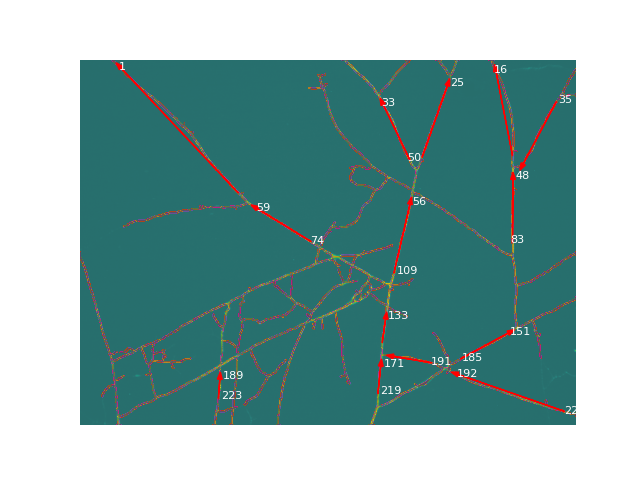

In [192]:
plt.close("all")
kernel = np.ones((3, 3), np.uint8)

fig, ax = plt.subplots()
ax.imshow(image)
ax.imshow(cv2.dilate(skeletonized.astype(np.uint8), kernel, iterations=1),alpha=0.7,cmap='Dark2')
plotted = []
for edge in edges:
    slices, segments = extract_section_profiles_for_edge(
    edge,
    pos,
    image,
    nx_graph_pruned,
    resolution=1,
    offset=4,
    step=15,
    target_length=10,
)
    pos_begin= np.mean(segments[10],axis=0)
    pos_end = np.mean(segments[-10],axis=0)
    vector = pos_end-pos_begin
    # plot_segments_on_image(segments,ax)
    if not edge[0] in plotted:
        plotted.append(edge[0])
        ax.text(*np.flip(segments[10][0]),str(edge[0]),color="white",fontsize = 8)
    if not edge[1] in plotted:
        plotted.append(edge[1])
        ax.text(*np.flip(segments[-10][0]),str(edge[1]),color="white",fontsize = 8)
    ax.arrow(pos_begin[1],pos_begin[0],vector[1],vector[0],color="red",head_width=10, head_length=15)
plt. axis('off')
plt.savefig('figures_biomec/figure_1.png',dpi=500)
# plt.title("Slices taken along one hypha")

In [128]:
kymos[(35,48)] = get_kymo((35,48),pos,selection_file,nx_graph_pruned)


In [181]:
# kymos = {edge:get_kymo(edge,pos,selection_file,nx_graph_pruned) for edge in edges}
filtered_kymos = {edge: filter_kymo(kymos[edge]) for edge in edges}
W = 30          # window size is WxW
time_pixel_size = 0.10 #s.pixel
space_pixel_size = 1.725 #um.pixel
speeds = {}
for edge in edges:
    imgCoherency, imgOrientation = calcGST(filtered_kymos[edge][1], W)
    speeds[edge]=np.tan((imgOrientation-90)/180*np.pi)*space_pixel_size/time_pixel_size #um.s-1
    speeds[edge]=speeds[edge][:,:300]
# corrs = {}
# for edge in edges:
#     to_treat = (speeds[edge]-np.mean(speeds[edge]))/np.std(speeds[edge])
#     corr = signal.correlate2d(to_treat, to_treat)
#     corrs[edge]=corr/np.max(corr)

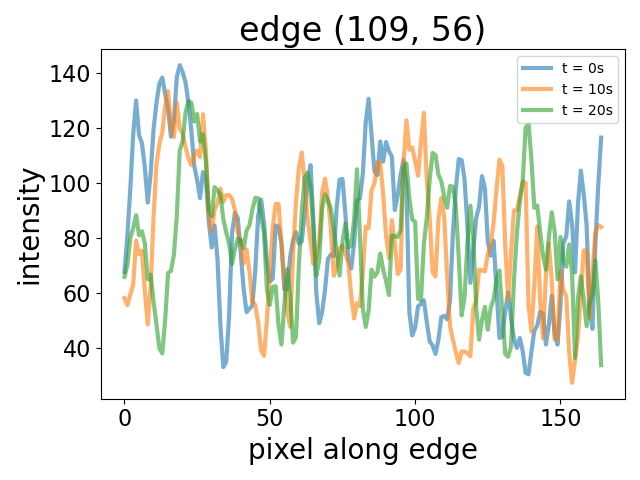

In [116]:
fig, ax = plt.subplots()
i=0
for j in [0,100,200]:
    ax.plot(kymos[edges[i]][j,:],label = f't = {j//10}s',alpha = 0.6)
ax.set_xlabel("pixel along edge")
ax.set_ylabel("intensity")
plt.title(f'edge {edges[i]}')
plt.legend()

plt.tight_layout()
plt.savefig('figures_biomec/figure_2.png',dpi=72)



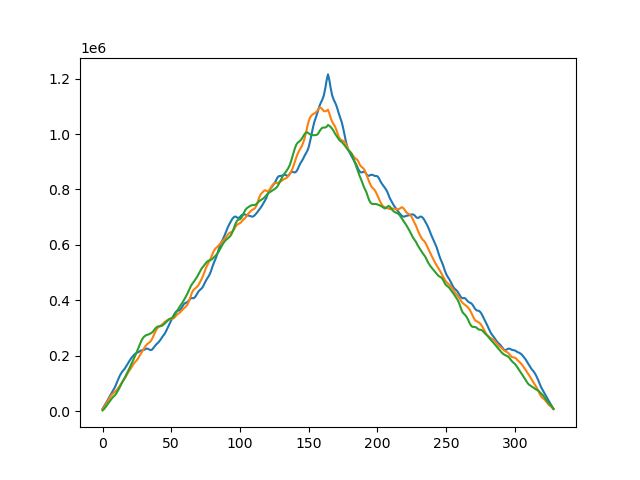

In [82]:
fig, ax = plt.subplots()
ax.plot(signal.correlate(kymos[edges[i]][0,:],kymos[edges[i]][0,:]))
ax.plot(signal.correlate(kymos[edges[i]][0,:],kymos[edges[i]][100,:]))
ax.plot(signal.correlate(kymos[edges[i]][0,:],kymos[edges[i]][200,:]))


# kymos[edges[i]][j,:]

In [110]:
space_pixel_size*kymos[edges[i]].shape[1]

569.25

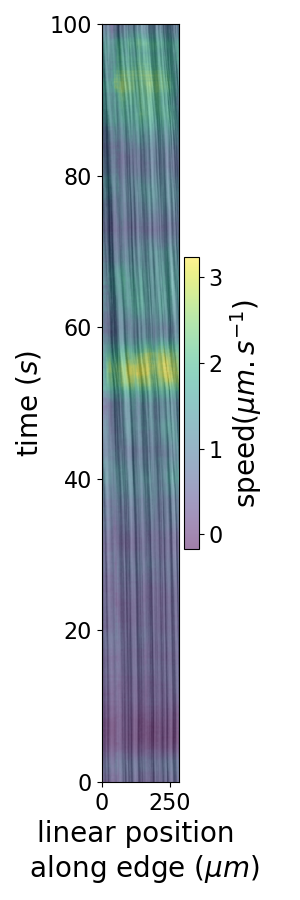

In [182]:
fig, ax = plt.subplots(figsize = (3,9))
i = 0
ax.imshow(filtered_kymos[edges[i]][1],cmap='gray',extent=[0,space_pixel_size*kymos[edges[i]].shape[1],0,100],aspect="auto")
mapable = ax.imshow(speeds[edges[i]],alpha=0.5,extent=[0,space_pixel_size*kymos[edges[i]].shape[1],0,100],aspect="auto")
cbar= plt.colorbar(mapable)
cbar.set_label('speed($\mu m.s^{-1}$)')
ax.set_xlabel('linear position \n along edge ($\mu m$)')
ax.set_ylabel('time ($s$)')

plt.tight_layout()
plt.savefig('figures_biomec/figure_3.png',dpi=72)

# ax.set_title(str(edges[i]))

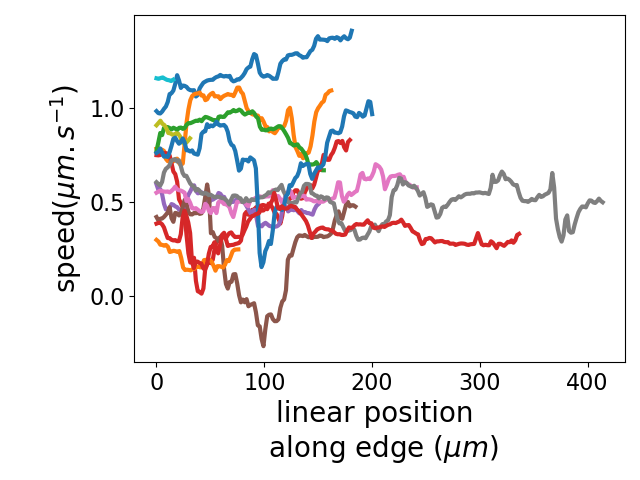

In [205]:
i=2
fig, ax = plt.subplots()
width = 20
signals = {}
for edge in edges:
    for t in [300]:
        signal = np.mean(speeds[edge][t:t+width,:][:,W:-W],axis=0)
        signals[edge]=signal
        length_time= space_pixel_size*len(signal)
        xs = np.linspace(0,length_time,len(signal))
        ax.plot(xs,signal,label = edge)
ax.set_xlabel('linear position \n along edge ($\mu m$)')
ax.set_ylabel('speed($\mu m.s^{-1}$)')
plt.tight_layout()
plt.savefig('figures_biomec/figure_6.png',dpi=72)
# plt.legend()

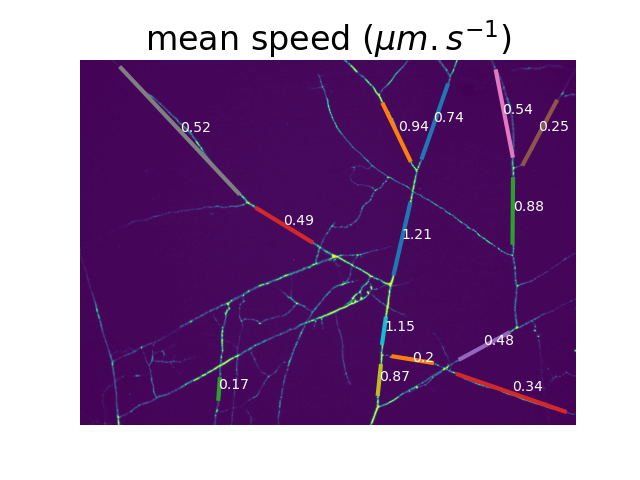

In [236]:
fig, ax = plt.subplots()
ax.imshow(image)
# ax.imshow(cv2.dilate(skeletonized.astype(np.uint8), kernel, iterations=1),alpha=0.7,cmap='Dark2')
plotted = []
for edge in edges:
    slices, segments = extract_section_profiles_for_edge(
    edge,
    pos,
    image,
    nx_graph_pruned,
    resolution=1,
    offset=4,
    step=15,
    target_length=10,
)
    pos_begin= np.mean(segments[10],axis=0)
    pos_end = np.mean(segments[-10],axis=0)
    vector = pos_end-pos_begin
    # plot_segments_on_image(segments,ax)
    if not edge[0] in plotted:
        plotted.append(edge[0])
        # ax.text(*np.flip(segments[10][0]),str(edge[0]),color="white",fontsize = 8)
    if not edge[1] in plotted:
        plotted.append(edge[1])
        # ax.text(*np.flip(segments[-10][0]),str(edge[1]),color="white",fontsize = 8)
    ax.plot([pos_begin[1],pos_end[1]],[pos_begin[0],pos_end[0]])    
    ax.text(*np.flip(np.mean([pos[edge[0]],pos[edge[1]]],axis=0)),round(np.mean(signals[edge]),2),color="white")
plt. axis('off')
plt.title('mean speed ($\mu m.s^{-1}$)')
plt.savefig('figures_biomec/figure_5.png',dpi=500)

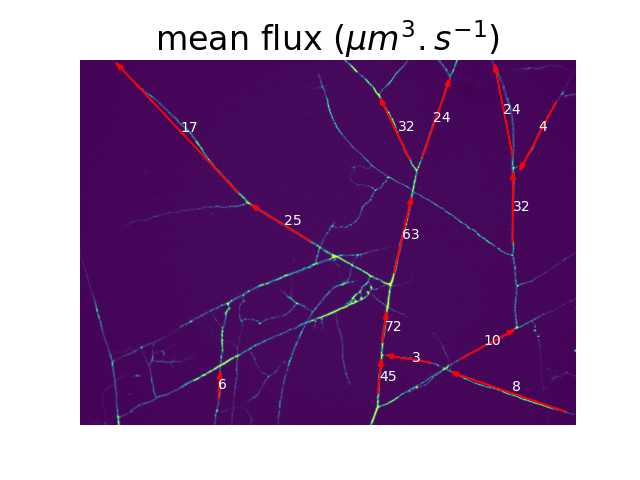

In [242]:
fig, ax = plt.subplots()
ax.imshow(image)
# ax.imshow(cv2.dilate(skeletonized.astype(np.uint8), kernel, iterations=1),alpha=0.7,cmap='Dark2')
plotted = []
for edge in edges:
    slices, segments = extract_section_profiles_for_edge(
    edge,
    pos,
    image,
    nx_graph_pruned,
    resolution=1,
    offset=4,
    step=15,
    target_length=10,
)
    pos_begin= np.mean(segments[10],axis=0)
    pos_end = np.mean(segments[-10],axis=0)
    vector = pos_end-pos_begin
    # plot_segments_on_image(segments,ax)
    if not edge[0] in plotted:
        plotted.append(edge[0])
        # ax.text(*np.flip(segments[10][0]),str(edge[0]),color="white",fontsize = 8)
    if not edge[1] in plotted:
        plotted.append(edge[1])
        # ax.text(*np.flip(segments[-10][0]),str(edge[1]),color="white",fontsize = 8)
    ax.arrow(pos_begin[1],pos_begin[0],vector[1],vector[0],color="red",head_width=10, head_length=15)
    ax.text(*np.flip(np.mean([pos[edge[0]],pos[edge[1]]],axis=0)),int(widths[edge]**2*np.mean(signals[edge])),color="white")
plt. axis('off')
plt.title('mean flux ($\mu m^3.s^{-1}$)')

plt.savefig('figures_biomec/figure_7.png',dpi=500)

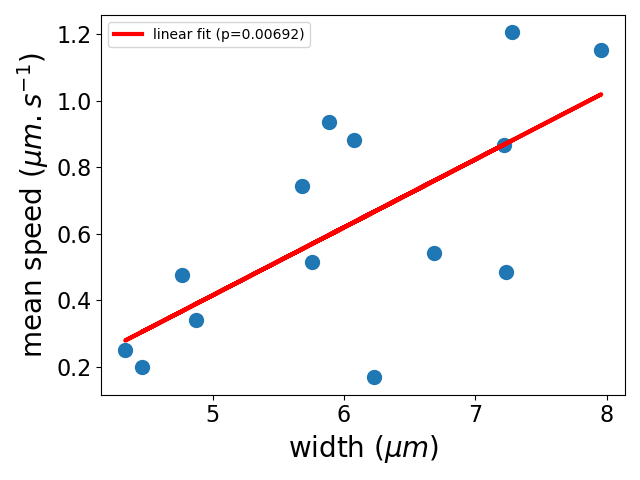

In [252]:
from sklearn.linear_model import LinearRegression
from scipy.stats.stats import pearsonr
width_points = [widths[edge] for edge in edges]
speed_points = [np.mean(signals[edge])for edge in edges]
X = np.array(width_points)
X = np.reshape(X,(X.shape[0],1))
y = np.array(speed_points)
p = pearsonr(np.array(width_points), y)[1]
reg = LinearRegression().fit(X, y)
fig,ax = plt.subplots()
ax.scatter(width_points,speed_points)
ax.plot(X,reg.predict(X),color='red',label=f'linear fit (p={round(p,5)})')
ax.set_xlabel('width ($\mu m$)')
ax.set_ylabel('mean speed ($\mu m.s^{-1}$)')
plt.tight_layout()
plt.savefig('figures_biomec/figure_8.png',dpi=500)
plt.legend()
# ax.set

(0.6845616755320777, 0.006916068093490371)

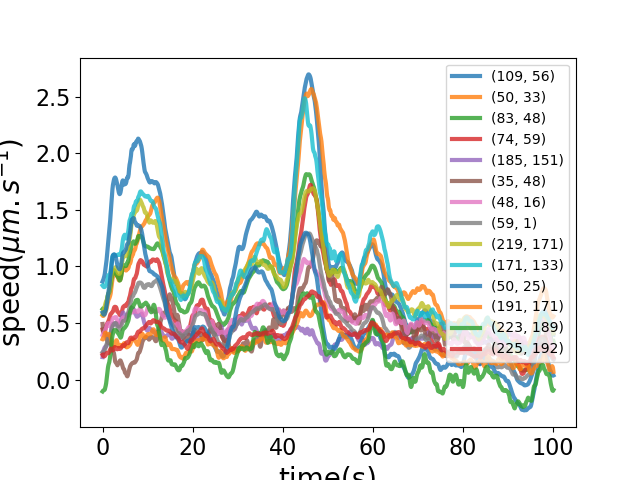

In [187]:
mean_speed = {edge:np.mean(speeds[edge],axis=1) for edge in edges}
mean_speed_smooth = {edge:scipy.signal.savgol_filter(np.mean(speeds[edge],axis=1),11,3) for edge in edges}

fig,ax = plt.subplots()
for edge in edges:
    ax.plot(np.array(range(len(mean_speed[edge])))*time_pixel_size,mean_speed_smooth[edge],label=edge,alpha=0.8)
ax.set_xlabel('time(s)')
ax.set_ylabel('speed($\mu m.s^{-1}$)')
plt.legend()

[array([0.3178029 , 0.34945807, 0.38140318, ..., 0.24930443, 0.21422857,
        0.21388996], dtype=float32),
 array([0.31173423, 0.30265576, 0.29454997, ..., 0.42428342, 0.3482897 ,
        0.34795472], dtype=float32),
 array([0.17961577, 0.22638057, 0.2728442 , ..., 0.28539225, 0.23760071,
        0.23761836], dtype=float32),
 array([0.29751253, 0.26284063, 0.22788227, ..., 0.21641047, 0.17865786,
        0.1785739 ], dtype=float32),
 array([-0.155744  , -0.04702071,  0.05950194, ...,  0.2892439 ,
         0.25417635,  0.2554041 ], dtype=float32),
 array([0.5512614 , 0.54176456, 0.54209024, ..., 0.4473406 , 0.49684775,
        0.4929585 ], dtype=float32),
 array([0.33789772, 0.35014397, 0.363199  , ..., 0.21985835, 0.16866007,
        0.16808957], dtype=float32),
 array([0.114517  , 0.11525223, 0.11583715, ..., 0.10528488, 0.08580095,
        0.08614586], dtype=float32),
 array([0.30322608, 0.34963453, 0.39501294, ..., 0.44385636, 0.38297006,
        0.38171497], dtype=float32),
 arr

In [ ]:
fig, ax = plt.subplots()
ax.plot(signal.correlate(kymos[edges[i]][0,:],kymos[edges[i]][0,:]))
ax.plot(signal.correlate(kymos[edges[i]][0,:],kymos[edges[i]][100,:]))
ax.plot(signal.correlate(kymos[edges[i]][0,:],kymos[edges[i]][200,:]))